In [2]:
import os, glob, time, datetime
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import torch
import torch.nn as nn
from torchvision.utils import save_image

from common.dataset import TrainDataProvider
from common.function import init_embedding
from common.models import Encoder, Decoder, Discriminator, Generator
from common.utils import denorm_image

### GPU Option

In [4]:
GPU = torch.cuda.is_available()
GPU

True

### Path Setting

In [5]:
data_dir = './dataset/'
model_dir = './model_save/'
fixed_dir = './fixed_sample'

### Get Fixed sample

In [6]:
fixed_sources, fixed_targets, fixed_labels = [], [], []

# font별 fixed target
for i in range(25):
    source = torch.load(os.path.join(fixed_dir, 'fixed_source_%d.pkl' % i))
    target = torch.load(os.path.join(fixed_dir, 'fixed_target_%d.pkl' % i))
    label = torch.load(os.path.join(fixed_dir, 'fixed_label_%d.pkl' % i))
    fixed_sources.append(source)
    fixed_targets.append(target)
    fixed_labels.append(label)
    
# 모든 폰트가 섞여있는 target
source = torch.load(os.path.join(fixed_dir, 'fixed_source_all.pkl'))
target = torch.load(os.path.join(fixed_dir, 'fixed_target_all.pkl'))
label = torch.load(os.path.join(fixed_dir, 'fixed_label_all.pkl'))
fixed_sources.append(source)
fixed_targets.append(target)
fixed_labels.append(label)

print("fixed sources:", len(fixed_sources))
print("fixed targets:", len(fixed_targets))
print("fixed labels:", len(fixed_labels))

fixed sources: 26
fixed targets: 26
fixed labels: 26


### fixed_source는 일단 폰트 다 섞여있는 걸로 지정

In [7]:
fixed_source = fixed_sources[-1]
fixed_target = fixed_targets[-1]
fixed_label = fixed_labels[-1]

In [31]:
fixed_label

tensor([ 7,  2, 20, 22, 11, 16, 20,  6, 14, 20,  6, 19,  4,  8, 15, 17, 20, 24,
        19, 10,  6,  0, 20, 19, 16,  7,  4, 20, 19, 13, 20, 23],
       device='cuda:0')

### Get Fixed Embedding

In [8]:
embeddings = torch.load(os.path.join(fixed_dir, 'EMBEDDINGS.pkl'))
embeddings.shape

torch.Size([100, 1, 1, 128])

### Hyper Parameter Setting

In [9]:
FONTS_NUM = 25
EMBEDDING_NUM = 100
BATCH_SIZE = 32
IMG_SIZE = 128
EMBEDDING_DIM = 128

### Data Provider

In [8]:
data_provider = TrainDataProvider(data_dir)
total_batches = data_provider.compute_total_batch_num(BATCH_SIZE)
print("total batches:", total_batches)

unpickled total 181619 examples
unpickled total 45040 examples
train examples -> 181619, val examples -> 45040
total batches: 5676


In [11]:
def train(max_epoch, schedule, data_dir, save_path, to_model_path, lr=0.001, \
          log_step=100, sample_step=350, fine_tune=False, flip_labels=False, \
          restore=None, from_model_path=False, GPU=True):
    
    # Fine Tuning coefficient
    if not fine_tune:
        L1_penalty, Lconst_penalty = 100, 15
    else:
        L1_penalty, Lconst_penalty = 500, 1000

    # Get Models
    En = Encoder()
    De = Decoder()
    D = Discriminator(category_num=FONTS_NUM)
    if GPU:
        En.cuda()
        De.cuda()
        D.cuda()
    
    # Use pre-trained Model
    # restore에 [encoder_path, decoder_path, discriminator_path] 형태로 인자 넣기
    if restore:
        encoder_path, decoder_path, discriminator_path = restore
        prev_epoch = int(encoder_path.split('-')[0])
        En.load_state_dict(torch.load(os.path.join(from_model_path, encoder_path)))
        De.load_state_dict(torch.load(os.path.join(from_model_path, decoder_path)))
        D.load_state_dict(torch.load(os.path.join(from_model_path, discriminator_path)))
        print("%d epoch trained model has restored" % prev_epoch)
    else:
        prev_epoch = 0
        print("New model training start")

        
    # L1 loss, binary real/fake loss, category loss, constant loss
    if GPU:
        l1_criterion = nn.L1Loss(size_average=True).cuda()
        bce_criterion = nn.BCEWithLogitsLoss(size_average=True).cuda()
        mse_criterion = nn.MSELoss(size_average=True).cuda()
    else:
        l1_criterion = nn.L1Loss(size_average=True)
        bce_criterion = nn.BCEWithLogitsLoss(size_average=True)
        mse_criterion = nn.MSELoss(size_average=True)


    # optimizer
    G_parameters = list(En.parameters()) + list(De.parameters())
    g_optimizer = torch.optim.Adam(G_parameters, betas=(0.5, 0.999))
    d_optimizer = torch.optim.Adam(D.parameters(), betas=(0.5, 0.999))
    
    # losses lists
    l1_losses, const_losses, category_losses, d_losses, g_losses = list(), list(), list(), list(), list()
    
    # training
    count = 0
    for epoch in range(max_epoch):
        if (epoch + 1) % schedule == 0:
            updated_lr = max(lr/2, 0.0002)
            for param_group in d_optimizer.param_groups:
                param_group['lr'] = updated_lr
            for param_group in g_optimizer.param_groups:
                param_group['lr'] = updated_lr
            if lr !=  updated_lr:
                print("decay learning rate from %.5f to %.5f" % (lr, updated_lr))
            lr = updated_lr
            
        train_batch_iter = data_provider.get_train_iter(BATCH_SIZE)   
        for i, batch in enumerate(train_batch_iter):
            labels, batch_images = batch
            embedding_ids = labels
            if GPU:
                batch_images = batch_images.cuda()
            if flip_labels:
                np.random.shuffle(embedding_ids)
                
            # target / source images
            real_target = batch_images[:, 0, :, :].view([BATCH_SIZE, 1, IMG_SIZE, IMG_SIZE])
            real_source = batch_images[:, 1, :, :].view([BATCH_SIZE, 1, IMG_SIZE, IMG_SIZE])
            
            # generate fake image form source image
            fake_target, encoded_source = Generator(real_source, En, De, embeddings, embedding_ids, GPU=GPU)
            
            real_TS = torch.cat([real_source, real_target], dim=1)
            fake_TS = torch.cat([real_source, fake_target], dim=1)
            
            # Scoring with Discriminator
            real_score, real_score_logit, real_cat_logit = D(real_TS)
            fake_score, fake_score_logit, fake_cat_logit = D(fake_TS)
            
            # Get encoded fake image to calculate constant loss
            encoded_fake = En(fake_target)[0]
            const_loss = Lconst_penalty * mse_criterion(encoded_source, encoded_fake)
            
            # category loss
            real_category = torch.from_numpy(np.eye(FONTS_NUM)[embedding_ids]).float()
            if GPU:
                real_category = real_category.cuda()
            real_category_loss = bce_criterion(real_cat_logit, real_category)
            fake_category_loss = bce_criterion(fake_cat_logit, real_category)
            category_loss = 0.5 * (real_category_loss + fake_category_loss)
            
            # labels
            if GPU:
                one_labels = torch.ones([BATCH_SIZE, 1]).cuda()
                zero_labels = torch.zeros([BATCH_SIZE, 1]).cuda()
            else:
                one_labels = torch.ones([BATCH_SIZE, 1])
                zero_labels = torch.zeros([BATCH_SIZE, 1])
            
            # binary loss - T/F
            real_binary_loss = bce_criterion(real_score_logit, one_labels)
            fake_binary_loss = bce_criterion(fake_score_logit, zero_labels)
            binary_loss = real_binary_loss + fake_binary_loss
            
            # L1 loss between real and fake images
            l1_loss = L1_penalty * l1_criterion(real_target, fake_target)
            
            # cheat loss for generator to fool discriminator
            cheat_loss = bce_criterion(fake_score_logit, one_labels)
            
            # g_loss, d_loss
            g_loss = cheat_loss + l1_loss + fake_category_loss + const_loss
            d_loss = binary_loss + category_loss
            
            # train Discriminator
            D.zero_grad()
            d_loss.backward(retain_graph=True)
            d_optimizer.step()
            
            # train Generator
            En.zero_grad()
            De.zero_grad()
            g_loss.backward(retain_graph=True)
            g_optimizer.step()            
            
            # loss data
            l1_losses.append(l1_loss.data)
            const_losses.append(const_loss.data)
            category_losses.append(category_loss.data)
            d_losses.append(d_loss.data)
            g_losses.append(g_loss.data)
            
            # logging
            if (i+1) % log_step == 0:
                time_ = time.time()
                time_stamp = datetime.datetime.fromtimestamp(time_).strftime('%H:%M:%S')
                log_format = 'Epoch [%d/%d], step [%d/%d], l1_loss: %.4f, d_loss: %.4f, g_loss: %.4f' % \
                             (int(prev_epoch)+epoch+1, int(prev_epoch)+max_epoch, i+1, total_batches, \
                              l1_loss.item(), d_loss.item(), g_loss.item())
                print(time_stamp, log_format)
                
            # save image
            if (i+1) % sample_step == 0:
                fixed_fake_images = Generator(fixed_source, En, De, embeddings, fixed_label, GPU=GPU)[0]
                save_image(denorm_image(fixed_fake_images.data), \
                           os.path.join(save_path, 'fake_samples-%d-%d.png' % (int(prev_epoch)+epoch+1, i+1)), \
                           nrow=8)
        
        if (epoch+1) % 5 == 0:
            now = datetime.datetime.now()
            now_date = now.strftime("%m%d")
            now_time = now.strftime('%H:%M')
            torch.save(En.state_dict(), os.path.join(to_model_path, '%d-%s-%s-Encoder.pkl' \
                                                     % (int(prev_epoch)+epoch+1, now_date, now_time)))
            torch.save(De.state_dict(), os.path.join(to_model_path, '%d-%s-%s-Decoder.pkl' % \
                                                     (int(prev_epoch)+epoch+1, now_date, now_time)))
            torch.save(D.state_dict(), os.path.join(to_model_path, '%d-%s-%s-Discriminator.pkl' % \
                                                    (int(prev_epoch)+epoch+1, now_date, now_time)))

    # save model
    total_epoch = int(prev_epoch) + int(max_epoch)
    end = datetime.datetime.now()
    end_date = end.strftime("%m%d")
    end_time = end.strftime('%H:%M')
    torch.save(En.state_dict(), os.path.join(to_model_path, \
                                             '%d-%s-%s-Encoder.pkl' % (total_epoch, end_date, end_time)))
    torch.save(De.state_dict(), os.path.join(to_model_path, \
                                             '%d-%s-%s-Decoder.pkl' % (total_epoch, end_date, end_time)))
    torch.save(D.state_dict(), os.path.join(to_model_path, \
                                            '%d-%s-%s-Discriminator.pkl' % (total_epoch, end_date, end_time)))
    losses = [l1_losses, const_losses, category_losses, d_losses, g_losses]
    torch.save(losses, os.path.join(to_model_path, '%d-losses.pkl' % max_epoch))

    return l1_losses, const_losses, category_losses, d_losses, g_losses

### sample 많이 저장하기위해서 1 epoch 먼저 돌리기

In [11]:
save_path = './fixed_fake/'
to_model_path = './model_checkpoint/'
losses = train(max_epoch=1, schedule=20, data_dir=data_dir, save_path=save_path, \
               to_model_path=to_model_path, log_step=500, sample_step=300)

New model training start
11:54:55 Epoch [1/1], step [500/5676], l1_loss: 31.2739, d_loss: 0.9409, g_loss: 34.6462
11:56:55 Epoch [1/1], step [1000/5676], l1_loss: 31.8447, d_loss: 1.2998, g_loss: 38.5265
11:58:54 Epoch [1/1], step [1500/5676], l1_loss: 24.1437, d_loss: 0.8289, g_loss: 27.2304
12:00:54 Epoch [1/1], step [2000/5676], l1_loss: 18.8942, d_loss: 0.7381, g_loss: 19.8360
12:02:53 Epoch [1/1], step [2500/5676], l1_loss: 20.9207, d_loss: 0.6053, g_loss: 22.5444
12:04:53 Epoch [1/1], step [3000/5676], l1_loss: 20.5315, d_loss: 0.5963, g_loss: 22.2178
12:06:53 Epoch [1/1], step [3500/5676], l1_loss: 18.0805, d_loss: 1.2983, g_loss: 21.9919
12:08:52 Epoch [1/1], step [4000/5676], l1_loss: 20.5686, d_loss: 0.1097, g_loss: 23.5190
12:10:52 Epoch [1/1], step [4500/5676], l1_loss: 17.4698, d_loss: 0.4321, g_loss: 19.3904
12:12:51 Epoch [1/1], step [5000/5676], l1_loss: 19.7424, d_loss: 0.1159, g_loss: 22.4151
12:14:50 Epoch [1/1], step [5500/5676], l1_loss: 18.3960, d_loss: 0.1931, g_

### 그 후에는 sample step 높여서 계속 돌리기

- 5/25, 12:38 시작

In [12]:
save_path = './fixed_fake/'
restore = ['1-0525-12:15-Encoder.pkl', '1-0525-12:15-Decoder.pkl', '1-0525-12:15-Discriminator.pkl']
from_model_path = './model_checkpoint/'
to_model_path = './model_checkpoint/'
losses = train(max_epoch=19, schedule=20, data_dir=data_dir, save_path=save_path, \
               to_model_path=to_model_path, log_step=1000, sample_step=500, \
               restore=restore, from_model_path=from_model_path)

1 epoch trained model has restored
15:38:01 Epoch [2/20], step [1000/5676], l1_loss: 16.1662, d_loss: 0.4008, g_loss: 18.5736
15:42:00 Epoch [2/20], step [2000/5676], l1_loss: 17.6748, d_loss: 0.5661, g_loss: 20.3574
15:45:59 Epoch [2/20], step [3000/5676], l1_loss: 16.8785, d_loss: 0.0855, g_loss: 21.0184
15:49:59 Epoch [2/20], step [4000/5676], l1_loss: 19.8407, d_loss: 0.2343, g_loss: 22.1844
15:53:58 Epoch [2/20], step [5000/5676], l1_loss: 18.1891, d_loss: 0.0298, g_loss: 24.0045
16:00:39 Epoch [3/20], step [1000/5676], l1_loss: 20.6264, d_loss: 0.0263, g_loss: 27.3629
16:04:38 Epoch [3/20], step [2000/5676], l1_loss: 17.9419, d_loss: 0.1640, g_loss: 21.8429
16:08:38 Epoch [3/20], step [3000/5676], l1_loss: 18.8312, d_loss: 0.0609, g_loss: 23.2616
16:12:37 Epoch [3/20], step [4000/5676], l1_loss: 17.0126, d_loss: 0.1591, g_loss: 20.0837
16:16:36 Epoch [3/20], step [5000/5676], l1_loss: 17.5264, d_loss: 0.0760, g_loss: 21.1012
16:23:17 Epoch [4/20], step [1000/5676], l1_loss: 17.58

22:25:17 Epoch [20/20], step [1000/5676], l1_loss: 16.4290, d_loss: 0.0186, g_loss: 22.7318
22:29:16 Epoch [20/20], step [2000/5676], l1_loss: 16.4366, d_loss: 1.2905, g_loss: 28.7268
22:33:15 Epoch [20/20], step [3000/5676], l1_loss: 16.9493, d_loss: 0.0128, g_loss: 24.6144
22:37:14 Epoch [20/20], step [4000/5676], l1_loss: 15.9653, d_loss: 0.0303, g_loss: 21.1287
22:41:13 Epoch [20/20], step [5000/5676], l1_loss: 15.8312, d_loss: 0.0093, g_loss: 21.6385


- 약 22분/1epoch : 3시간40분/10epoch


- 7시간 20분 / 20epoch

## Losses

In [13]:
l1_losses, const_losses, category_losses, d_losses, g_losses = losses

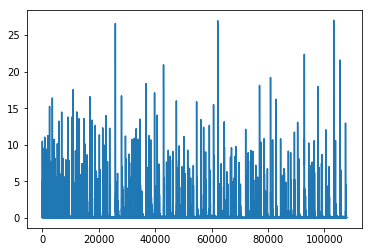

In [14]:
plt.plot(d_losses)
plt.show()

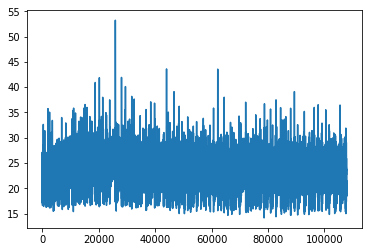

In [15]:
plt.plot(g_losses)
plt.show()

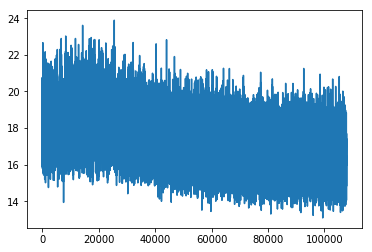

In [16]:
plt.plot(l1_losses)
plt.show()

### 바로 10epoch 더 돌리기

In [ ]:
save_path = './fixed_fake/'
restore = ['20-0525-22:43-Encoder.pkl', '20-0525-22:43-Decoder.pkl', '20-0525-22:43-Discriminator.pkl']
from_model_path = './model_checkpoint/'
to_model_path = './model_checkpoint/'
losses = train(max_epoch=9, schedule=20, data_dir=data_dir, save_path=save_path, \
               to_model_path=to_model_path, log_step=1000, sample_step=1000, \
               restore=restore, from_model_path=from_model_path)

20 epoch trained model has restored
23:52:01 Epoch [21/29], step [1000/5676], l1_loss: 18.2258, d_loss: 0.0115, g_loss: 25.6177
23:56:00 Epoch [21/29], step [2000/5676], l1_loss: 15.2904, d_loss: 0.0204, g_loss: 20.9109
23:59:59 Epoch [21/29], step [3000/5676], l1_loss: 16.5061, d_loss: 0.0227, g_loss: 21.6226
00:03:58 Epoch [21/29], step [4000/5676], l1_loss: 14.8611, d_loss: 0.0238, g_loss: 20.5865
00:07:57 Epoch [21/29], step [5000/5676], l1_loss: 16.6265, d_loss: 0.0139, g_loss: 23.8332
00:14:37 Epoch [22/29], step [1000/5676], l1_loss: 15.0601, d_loss: 0.0112, g_loss: 21.6688
00:18:36 Epoch [22/29], step [2000/5676], l1_loss: 16.1611, d_loss: 2.8056, g_loss: 16.4437
00:22:35 Epoch [22/29], step [3000/5676], l1_loss: 17.5555, d_loss: 0.0077, g_loss: 23.3962
00:26:34 Epoch [22/29], step [4000/5676], l1_loss: 16.8329, d_loss: 0.0138, g_loss: 24.9099
00:30:33 Epoch [22/29], step [5000/5676], l1_loss: 17.1667, d_loss: 0.0068, g_loss: 23.8528
00:37:14 Epoch [23/29], step [1000/5676], l1

- 25까지만 완성
- 25까지 learning_rate : `0.001`

### 각 폰트마다 상황 보기

In [10]:
En = Encoder().cuda()
De = Decoder().cuda()
D = Discriminator(category_num=FONTS_NUM).cuda()
from_model_path = './model_checkpoint/'
encoder_path = '25-0526-01:41-Encoder.pkl'
decoder_path = '25-0526-01:41-Decoder.pkl'
discriminator_path = '25-0526-01:41-Discriminator.pkl'

En.load_state_dict(torch.load(os.path.join(from_model_path, encoder_path)))
De.load_state_dict(torch.load(os.path.join(from_model_path, decoder_path)))
D.load_state_dict(torch.load(os.path.join(from_model_path, discriminator_path)))

IncompatibleKeys(missing_keys=[], unexpected_keys=[])

In [11]:
fixed_dir = './fixed_sample'

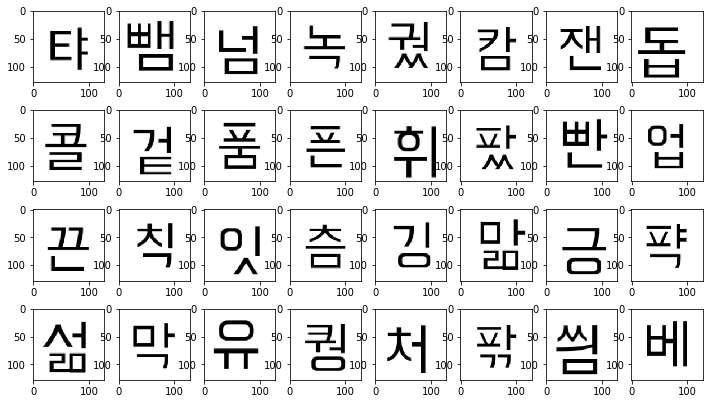

In [14]:
fixed_source_1 = torch.load(os.path.join(fixed_dir, 'fixed_source_1.pkl'))
fixed_label_1 = torch.load(os.path.join(fixed_dir, 'fixed_label_1.pkl'))
fixed_fake_images_1 = Generator(fixed_source_1, En, De, embeddings, fixed_label_1, GPU=GPU)[0]
fixed_target_1 = torch.load(os.path.join(fixed_dir, 'fixed_target_1.pkl'))

plt.figure(figsize=(12, 7))
for idx, image in enumerate(fixed_target_1):
    plt.subplot(4, 8, idx+1)
    plt.imshow(image.reshape(128, 128).cpu().numpy(), cmap='gray')
plt.show()

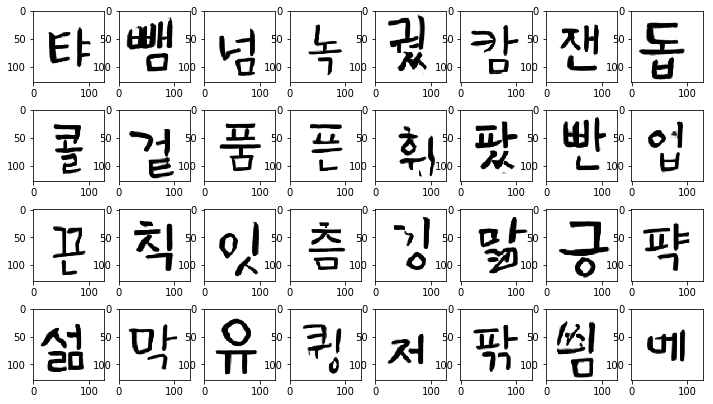

In [15]:
plt.figure(figsize=(12, 7))
for idx, image in enumerate(fixed_fake_images_1):
    plt.subplot(4, 8, idx+1)
    plt.imshow(image.reshape(128, 128).cpu().detach().numpy(), cmap='gray')
plt.show()

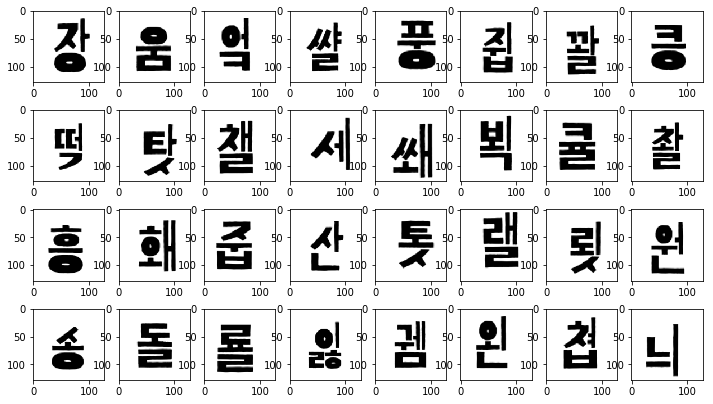

In [19]:
fixed_source_2 = torch.load(os.path.join(fixed_dir, 'fixed_source_2.pkl'))
fixed_label_3 = torch.load(os.path.join(fixed_dir, 'fixed_label_3.pkl'))
fixed_fake_images_2 = Generator(fixed_source_2, En, De, embeddings, fixed_label_3, GPU=GPU)[0]
fixed_target_2 = torch.load(os.path.join(fixed_dir, 'fixed_target_2.pkl'))

plt.figure(figsize=(12, 7))
for idx, image in enumerate(fixed_target_2):
    plt.subplot(4, 8, idx+1)
    plt.imshow(image.reshape(128, 128).cpu().numpy(), cmap='gray')
plt.show()

In [22]:
fixed_label_3

tensor([3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
        3, 3, 3, 3, 3, 3, 3, 3], device='cuda:0')

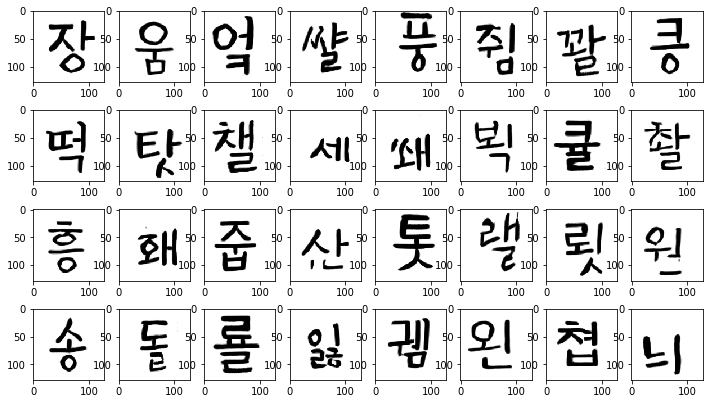

In [21]:
plt.figure(figsize=(12, 7))
for idx, image in enumerate(fixed_fake_images_2):
    plt.subplot(4, 8, idx+1)
    plt.imshow(image.reshape(128, 128).cpu().detach().numpy(), cmap='gray')
plt.show()

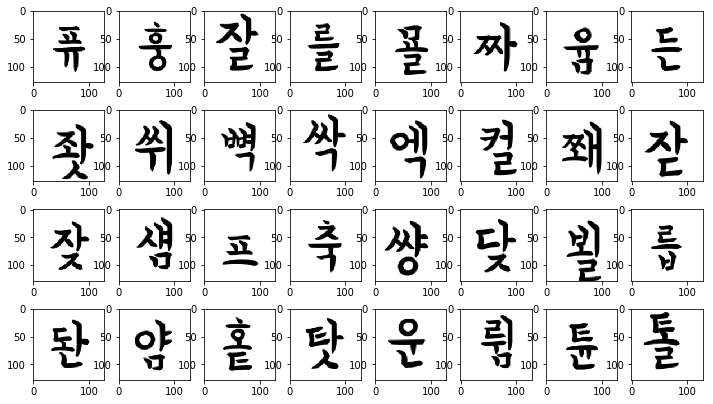

In [24]:
fixed_source_3 = torch.load(os.path.join(fixed_dir, 'fixed_source_3.pkl'))
fixed_label_3 = torch.load(os.path.join(fixed_dir, 'fixed_label_3.pkl'))
fixed_fake_images_3 = Generator(fixed_source_3, En, De, embeddings, fixed_label_3, GPU=GPU)[0]
fixed_target_3 = torch.load(os.path.join(fixed_dir, 'fixed_target_3.pkl'))

plt.figure(figsize=(12, 7))
for idx, image in enumerate(fixed_target_3):
    plt.subplot(4, 8, idx+1)
    plt.imshow(image.reshape(128, 128).cpu().numpy(), cmap='gray')
plt.show()

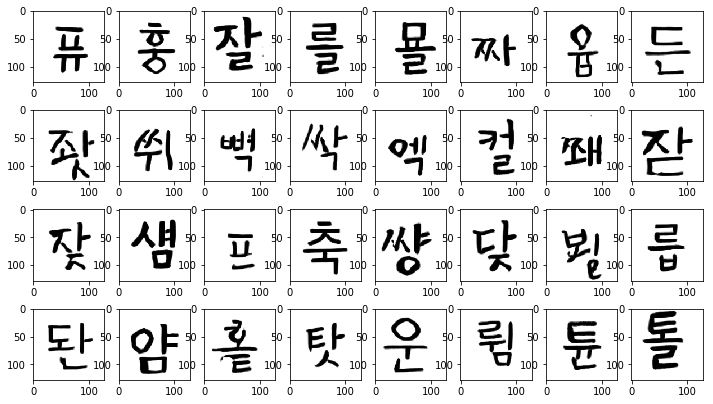

In [25]:
plt.figure(figsize=(12, 7))
for idx, image in enumerate(fixed_fake_images_3):
    plt.subplot(4, 8, idx+1)
    plt.imshow(image.reshape(128, 128).cpu().detach().numpy(), cmap='gray')
plt.show()

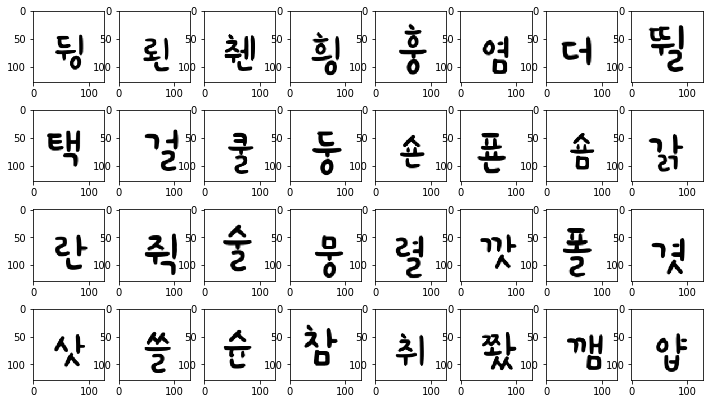

In [26]:
fixed_source_4 = torch.load(os.path.join(fixed_dir, 'fixed_source_4.pkl'))
fixed_label_4 = torch.load(os.path.join(fixed_dir, 'fixed_label_4.pkl'))
fixed_fake_images_4 = Generator(fixed_source_4, En, De, embeddings, fixed_label_4, GPU=GPU)[0]
fixed_target_4 = torch.load(os.path.join(fixed_dir, 'fixed_target_4.pkl'))

plt.figure(figsize=(12, 7))
for idx, image in enumerate(fixed_target_4):
    plt.subplot(4, 8, idx+1)
    plt.imshow(image.reshape(128, 128).cpu().numpy(), cmap='gray')
plt.show()

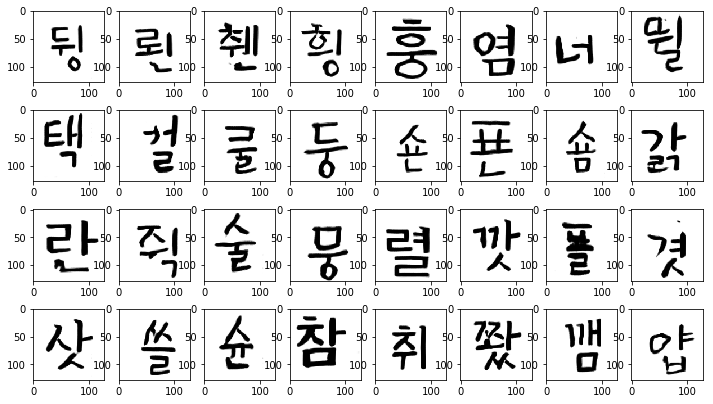

In [27]:
plt.figure(figsize=(12, 7))
for idx, image in enumerate(fixed_fake_images_4):
    plt.subplot(4, 8, idx+1)
    plt.imshow(image.reshape(128, 128).cpu().detach().numpy(), cmap='gray')
plt.show()

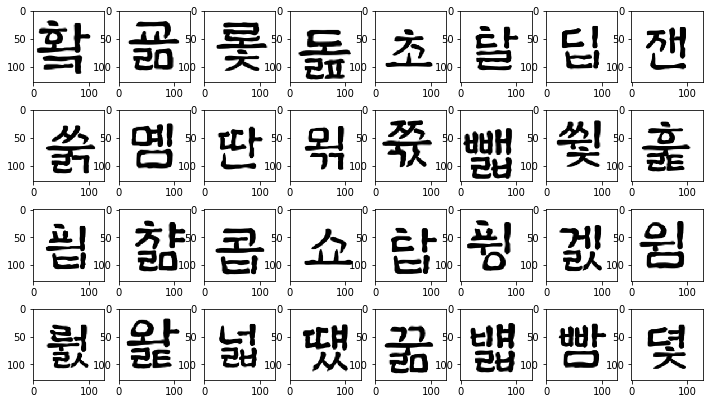

In [28]:
fixed_source_5 = torch.load(os.path.join(fixed_dir, 'fixed_source_5.pkl'))
fixed_label_5 = torch.load(os.path.join(fixed_dir, 'fixed_label_5.pkl'))
fixed_fake_images_5 = Generator(fixed_source_5, En, De, embeddings, fixed_label_5, GPU=GPU)[0]
fixed_target_5 = torch.load(os.path.join(fixed_dir, 'fixed_target_5.pkl'))

plt.figure(figsize=(12, 7))
for idx, image in enumerate(fixed_target_5):
    plt.subplot(4, 8, idx+1)
    plt.imshow(image.reshape(128, 128).cpu().numpy(), cmap='gray')
plt.show()

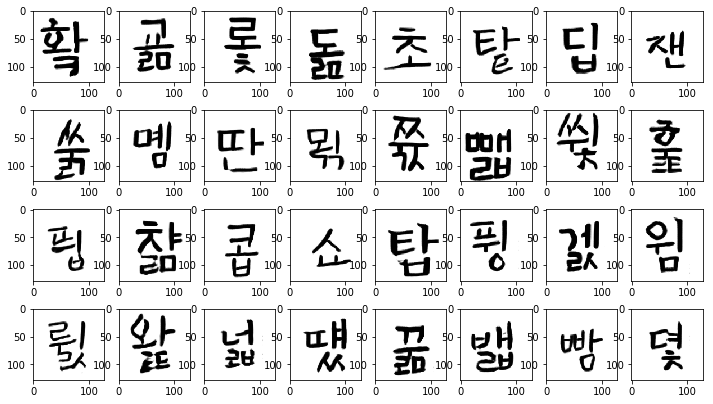

In [29]:
plt.figure(figsize=(12, 7))
for idx, image in enumerate(fixed_fake_images_5):
    plt.subplot(4, 8, idx+1)
    plt.imshow(image.reshape(128, 128).cpu().detach().numpy(), cmap='gray')
plt.show()

처참...ㅎ ㅎ ㅎ 더 돌려보자!